# Importing Libraries

In [ ]:
import pandas as pd
import pyarrow.parquet as pa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Importing Dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d dhoogla/cicids2017

Dataset URL: https://www.kaggle.com/datasets/dhoogla/cicids2017
License(s): CC-BY-NC-SA-4.0
100% 227M/227M [00:03<00:00, 82.3MB/s]
100% 227M/227M [00:03<00:00, 66.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/cicids2017.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
df_data_1 = pd.read_parquet('/content/Benign-Monday-no-metadata.parquet')
df_data_2 = pd.read_parquet('/content/Botnet-Friday-no-metadata.parquet')
df_data_3 = pd.read_parquet('/content/Bruteforce-Tuesday-no-metadata.parquet')
df_data_4 = pd.read_parquet('/content/DDoS-Friday-no-metadata.parquet')
df_data_5 = pd.read_parquet('/content/DoS-Wednesday-no-metadata.parquet')
df_data_6 = pd.read_parquet('/content/Infiltration-Thursday-no-metadata.parquet')
df_data_7 = pd.read_parquet('/content/Portscan-Friday-no-metadata.parquet')
df_data_8 = pd.read_parquet('/content/WebAttacks-Thursday-no-metadata.parquet')

In [ ]:
df_data = pd.concat([df_data_1, df_data_2, df_data_3, df_data_4,
                     df_data_5, df_data_6, df_data_7, df_data_8], axis=0, ignore_index=True)

In [ ]:
df_data.shape

(2313810, 78)

In [ ]:
df_data['Label'].value_counts()

,count
Label,
Benign,1977318
DoS Hulk,172846
DDoS,128014
DoS GoldenEye,10286
FTP-Patator,5931
DoS slowloris,5385
DoS Slowhttptest,5228
SSH-Patator,3219
PortScan,1956


In [ ]:
df_data['Label'].unique()

array(['Benign', 'Bot', 'FTP-Patator', 'SSH-Patator', 'DDoS',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed', 'Infiltration', 'PortScan',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection'], dtype=object)

# Data Undersampling


In [ ]:
df_data.columns

Index(['Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Fwd Packets Length Total',
       'Bwd Packets Length Total', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Count', 'RST Fla

In [ ]:
benign_total = len(df_data[df_data['Label'] == "Benign"])
benign_total

1977318

In [ ]:
attack_total = len(df_data[df_data['Label'] != "Benign"])
attack_total

336492

In [ ]:
enlargement = 1.1
benign_included_max = attack_total / 30 * 70
benign_inc_probability = (benign_included_max / benign_total) * enlargement
print(benign_included_max, benign_inc_probability)

785148.0 0.43678497844049363


In [ ]:
import random
indexes = []
benign_included_count = 0
for index, row in df_data.iterrows():
    if (row['Label'] != "Benign"):
        indexes.append(index)
    else:
        # Copying with benign_inc_probability
        if random.random() > benign_inc_probability: continue
        # Have we achieved 70% (5087 records)?
        if benign_included_count > benign_included_max: continue
        benign_included_count += 1
        indexes.append(index)
df_balanced = df_data.loc[indexes]

In [ ]:
df_balanced['Label'].value_counts()

,count
Label,
Benign,785149
DoS Hulk,172846
DDoS,128014
DoS GoldenEye,10286
FTP-Patator,5931
DoS slowloris,5385
DoS Slowhttptest,5228
SSH-Patator,3219
PortScan,1956


In [ ]:
benign_total_new = len(df_balanced[df_balanced['Label'] == "Benign"])
benign_total_new

785149

In [ ]:
attack_total_new = len(df_balanced[df_balanced['Label'] != "Benign"])
attack_total_new

336492

In [ ]:
benign_total = len(df_data[df_data['Label'] == "Benign"])
benign_total

1977318

In [ ]:
attack_total = len(df_data[df_data['Label'] != "Benign"])
attack_total

336492

In [ ]:
df_data['Label'].value_counts()

,count
Label,
Benign,1977318
DoS Hulk,172846
DDoS,128014
DoS GoldenEye,10286
FTP-Patator,5931
DoS slowloris,5385
DoS Slowhttptest,5228
SSH-Patator,3219
PortScan,1956


In [ ]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

# Model Training

In [ ]:
# Load dataset
data = pd.read_csv('web_attacks_balanced.csv')
data = data.dropna()

# Create a new binary target column: 1 for Web Attack, 0 for Benign
data['target_binary'] = data['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

# Split the data into features and target
X = data.drop(columns=['Label', 'target_binary'])
y = data['target_binary']

# Split the dataset into 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
def evaluate_model(model, X_test, y_test):
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    computing_time = end_time - start_time

    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)

    return accuracy, precision, recall, f1, computing_time, fpr, tpr, roc_auc

# Initialize models
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()
xgboost = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train and evaluate Decision Tree
decision_tree.fit(X_train, y_train)
acc_dt, prec_dt, rec_dt, f1_dt, time_dt, fpr_dt, tpr_dt, roc_auc_dt = evaluate_model(decision_tree, X_test, y_test)

# Train and evaluate Random Forest
random_forest.fit(X_train, y_train)
acc_rf, prec_rf, rec_rf, f1_rf, time_rf, fpr_rf, tpr_rf, roc_auc_rf = evaluate_model(random_forest, X_test, y_test)

# Train and evaluate XGBoost
xgboost.fit(X_train, y_train)
acc_xgb, prec_xgb, rec_xgb, f1_xgb, time_xgb, fpr_xgb, tpr_xgb, roc_auc_xgb = evaluate_model(xgboost, X_test, y_test)

# Print metrics
print(f'Decision Tree: Accuracy={acc_dt:.8f}, Precision={prec_dt:.8f}, Recall={rec_dt:.8f}, F1 Score={f1_dt:.8f}, Time={time_dt:.8f}s')
print(f'Random Forest: Accuracy={acc_rf:.8f}, Precision={prec_rf:.8f}, Recall={rec_rf:.8f}, F1 Score={f1_rf:.8f}, Time={time_rf:.8f}s')
print(f'XGBoost: Accuracy={acc_xgb:.8f}, Precision={prec_xgb:.8f}, Recall={rec_xgb:.8f}, F1 Score={f1_xgb:.8f}, Time={time_xgb:.8f}s')



/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:03:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Decision Tree: Accuracy=0.99869239, Precision=0.99869236, Recall=0.99869239, F1 Score=0.99869238, Time=0.18733382s
Random Forest: Accuracy=0.99841899, Precision=0.99841875, Recall=0.99841899, F1 Score=0.99841875, Time=7.86246586s
XGBoost: Accuracy=0.99904604, Precision=0.99904657, Recall=0.99904604, F1 Score=0.99904619, Time=0.97492003s


# Visualization and Plotting

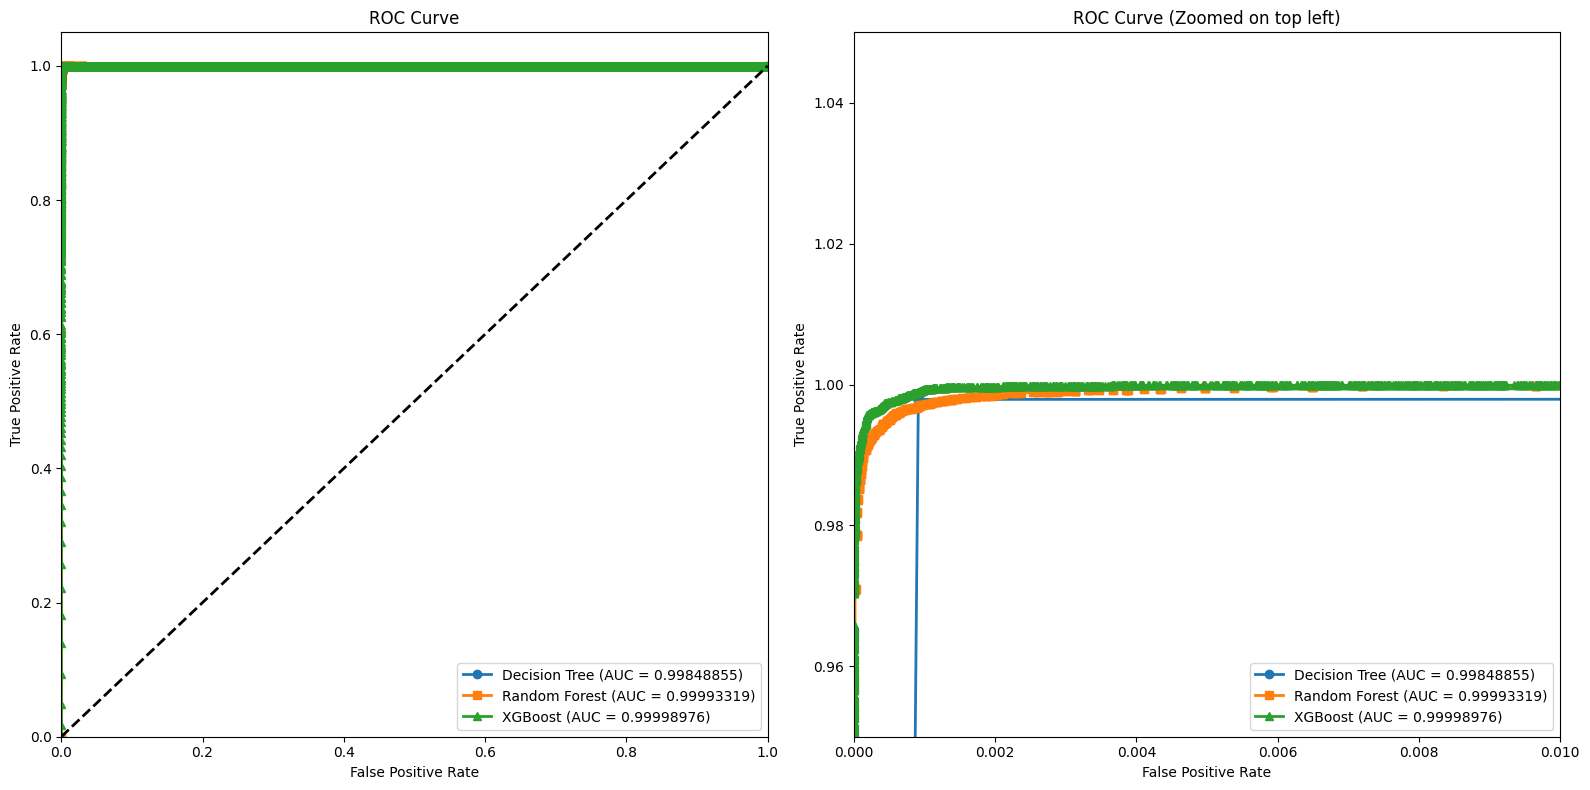

In [ ]:
plt.figure(figsize=(16, 8))

# Subplot 1: Standard ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.8f})', lw=2, marker='o')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.8f})', lw=2, marker='s')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.8f})', lw=2, marker='^')
plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Subplot 2: Zoomed-In ROC Curve
plt.subplot(1, 2, 2)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.8f})', lw=2, marker='o')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.8f})', lw=2, marker='s')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.8f})', lw=2, marker='^')
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Zooming in on the top-left corner
plt.xlim([0.0, 0.01])
plt.ylim([0.95, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Zoomed on top left)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [ ]:
# Function to plot the reliability curve
def plot_reliability_curve(y_test, y_prob, model_name):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{model_name}")

# Get predicted probabilities
y_prob_dt = decision_tree.predict_proba(X_test)[:, 1]
y_prob_rf = random_forest.predict_proba(X_test)[:, 1]
y_prob_xgb = xgboost.predict_proba(X_test)[:, 1]

# Plot the reliability curve
plt.figure(figsize=(8, 8))
plot_reliability_curve(y_test, y_prob_dt, f"DecisionTree (AUC = {roc_auc_dt:.8f})")
plot_reliability_curve(y_test, y_prob_rf, f"RandomForest (AUC = {roc_auc_rf:.8f})")
plot_reliability_curve(y_test, y_prob_xgb, f"XGBoost (AUC = {roc_auc_xgb:.8f})")

# Reference line
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")

plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability (Calibration) Curve")
plt.legend(loc="best")
plt.show()

NameError: name 'calibration_curve' is not defined

<Figure size 800x800 with 0 Axes>

In [ ]:
from sklearn.metrics import precision_recall_curve

# Calculate precision-recall curve
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_prob_dt)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)

# Plot the standard Precision-Recall curve
plt.figure(figsize=(16, 8))

# Subplot 1: Standard Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall_dt, precision_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.8f})', lw=2, marker='o')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {roc_auc_rf:.8f})', lw=2, marker='s')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.8f})', lw=2, marker='^')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")

# Subplot 2: Zoomed-In Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_dt, precision_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.8f})', lw=2, marker='o')
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {roc_auc_rf:.8f})', lw=2, marker='s')
plt.plot(recall_xgb, precision_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.8f})', lw=2, marker='^')

# Zoom in on the top-right corner
plt.xlim([0.8, 1.0])
plt.ylim([0.8, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Zoomed on top right)')
plt.legend(loc="best")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_dt = decision_tree.predict(X_test)

cm_dt = confusion_matrix(y_test, y_pred_dt)

disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt)
disp_dt.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Decision Tree')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_xgb = xgboost.predict(X_test)

cm_xgb = confusion_matrix(y_test, y_pred_xgb)

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for XGBoost")
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_rf = random_forest.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred_rf)

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest")
plt.show()
